# **Project - Insurance Claims Security**
## Project Problem Statement
This project is aiming to predict "how sever is a claim given some information about a particular claim".
Column 'loss' is our target variable needs to be predicted, and we will use the other columns as the input variables to make the prediction.

## Steps Done on the Project
1. Data Description    
2. Exploratory Data Analysis and Data Preparing       
3. Data Modeling    
4. Model Evaluation and Prediction    


In [2]:
!pip install bayesian-optimization
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import RandomizedSearchCV


## Step 1: Data Description
1.1 In this step, we read in the data and look at the first 5 rows to have a sense of the dataset, and check the missing values as well.

In [3]:
# Read in the dataset
df = pd.read_csv('/content/data.csv')

In [4]:
# Read the top 5 rows
df.head(5)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [5]:
# Print the data information, descriptive data, and show the data types of each column
print(df.info())
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB
None
id          int64
cat1       object
cat2       object
cat3       object
cat4       object
           ...   
cont11    float64
cont12    float64
cont13    float64
cont14    float64
loss      float64
Length: 132, dtype: object


In [6]:
# Check if there is any missing values in the dataset
df.isnull().values.any()

False

**Summary on this step:** This data set has 188318 rows and 132 column, including 116 categorical variables and 15 continuous variables, and here we don't see any missing values in this dataset.

## Step 2: Exloratory Data Analysis    
2.1 Check the caterogical columns and drop some columns if neeed

In [7]:
# Look at the categorical columns
df.columns[df.columns.str.startswith('cat')]

# Check each feature's percentage in the categorical columns
for x in df.columns[df.columns.str.startswith('cat')]:
    print(df[x].value_counts(normalize=True))

cat1
A    0.751654
B    0.248346
Name: proportion, dtype: float64
cat2
A    0.566706
B    0.433294
Name: proportion, dtype: float64
cat3
A    0.945173
B    0.054827
Name: proportion, dtype: float64
cat4
A    0.681799
B    0.318201
Name: proportion, dtype: float64
cat5
A    0.657064
B    0.342936
Name: proportion, dtype: float64
cat6
A    0.699312
B    0.300688
Name: proportion, dtype: float64
cat7
A    0.975711
B    0.024289
Name: proportion, dtype: float64
cat8
A    0.941355
B    0.058645
Name: proportion, dtype: float64
cat9
A    0.600697
B    0.399303
Name: proportion, dtype: float64
cat10
A    0.850758
B    0.149242
Name: proportion, dtype: float64
cat11
A    0.893096
B    0.106904
Name: proportion, dtype: float64
cat12
A    0.848697
B    0.151303
Name: proportion, dtype: float64
cat13
A    0.896627
B    0.103373
Name: proportion, dtype: float64
cat14
A    0.987909
B    0.012091
Name: proportion, dtype: float64
cat15
A    0.999819
B    0.000181
Name: proportion, dtype: float64
cat1

2.2 Check the continuous columns and drop all the outliers



In [8]:
# Select only the continuous columns
continuous_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the IQR
Q1 = df[continuous_columns].quantile(0.25)
Q3 = df[continuous_columns].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as anything outside 1.5 * IQR
outliers = df[(df[continuous_columns] < (Q1 - 1.5 * IQR)) | (df[continuous_columns] > (Q3 + 1.5 * IQR))]

# Drop off all the outliers
df_no_out = df[~outliers.any(axis=1)]
df_no_out.reset_index(drop=True,inplace=True)
df_no_out.shape

(162309, 132)

2.3 Split the dataset into categorical and continuous dataset, and check the distribution of the continuous variables without any outliers.

In [9]:
# Split out the continuous and categorical dateset
cont_df = df_no_out.select_dtypes(include=['float64', 'int64'])
cat_df = df_no_out.select_dtypes(include=['object'])

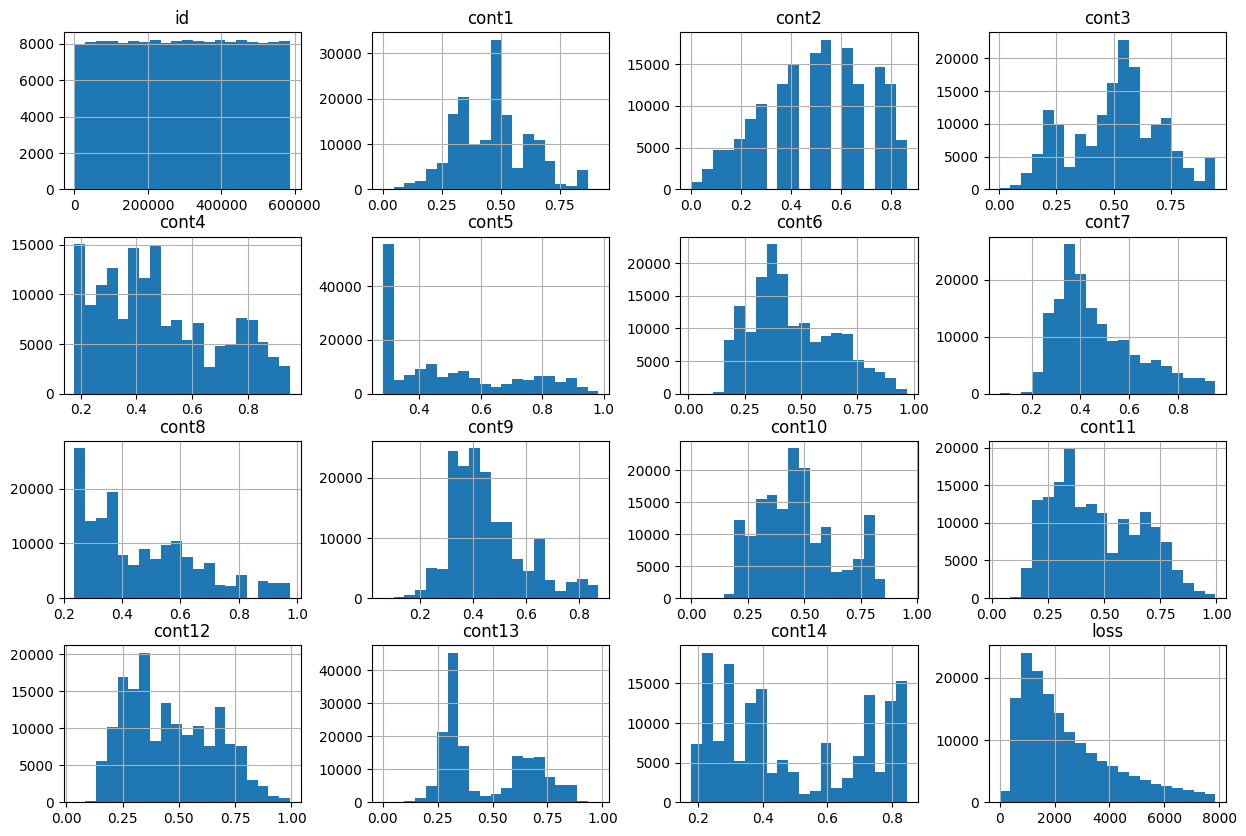

In [10]:
# Distribution of the continuous variables
cont_df.hist(bins=20, figsize=(15, 10))
plt.show()

2.4 Find the correlation matrix of each continuous variables and drop the highly correlated variables

In [11]:
# Compute the correlation matrix (for continuous variables)
corr_matrix = cont_df.corr()

# Create a mask to exclude self-correlation (correlation of a variable with itself)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Filter the correlation matrix to get only pairs with correlation > 0.8
high_corr = corr_matrix[~mask & (corr_matrix > 0.8)]

# Drop rows and columns where all values are NaN
high_corr = high_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)

print(high_corr)

           cont1     cont6   cont11
cont9   0.892383       NaN      NaN
cont10       NaN  0.855127      NaN
cont12       NaN       NaN  0.99574


In [12]:
# Identify columns to drop by selecting any highly correlated columns
to_drop = ['cont9', 'cont10', 'cont12']

# Drop these columns from the original dataframe
cont_df_final = cont_df.drop(columns=to_drop)

print(f"Columns to drop due to high correlation (> 0.8): {to_drop}")
print("\nReduced dataframe:")
print(cont_df_final)

Columns to drop due to high correlation (> 0.8): ['cont9', 'cont10', 'cont12']

Reduced dataframe:
            id     cont1     cont2     cont3     cont4     cont5     cont6  \
0            1  0.726300  0.245921  0.187583  0.789639  0.310061  0.718367   
1            2  0.330514  0.737068  0.592681  0.614134  0.885834  0.438917   
2            5  0.261841  0.358319  0.484196  0.236924  0.397069  0.289648   
3           10  0.321594  0.555782  0.527991  0.373816  0.422268  0.440945   
4           11  0.273204  0.159990  0.527991  0.473202  0.704268  0.178193   
...        ...       ...       ...       ...       ...       ...       ...   
162304  587619  0.228606  0.737068  0.527991  0.373816  0.422268  0.445008   
162305  587620  0.347403  0.785784  0.613660  0.473202  0.939556  0.242437   
162306  587624  0.507661  0.555782  0.549770  0.802892  0.704268  0.334270   
162307  587630  0.484469  0.785784  0.792378  0.189137  0.482436  0.345883   
162308  587632  0.438385  0.422197  0.29897

2.5 Dealing with categorical variables, use One-hot Encoder method to convert the categorical values to numerical values.

In [13]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid dummy variable trap if needed

# Fit and transform the categorical data
encoded_data = encoder.fit_transform(cat_df)

# Convert to a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_df.columns))

# Concatenate the original data (dropping original categorical columns) with the encoded DataFrame
cat_df_final = pd.concat([cat_df.drop(columns=cat_df.columns), encoded_df], axis=1)

print(cat_df_final)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


        cat1_B  cat2_B  cat3_B  cat4_B  cat5_B  cat6_B  cat7_B  cat8_B  \
0          0.0     1.0     0.0     1.0     0.0     0.0     0.0     0.0   
1          0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2          0.0     1.0     0.0     0.0     1.0     0.0     0.0     0.0   
3          1.0     1.0     0.0     1.0     0.0     0.0     0.0     0.0   
4          0.0     1.0     0.0     1.0     0.0     0.0     0.0     0.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
162304     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
162305     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
162306     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
162307     0.0     1.0     0.0     0.0     0.0     0.0     0.0     1.0   
162308     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   

        cat9_B  cat10_B  ...  cat116_MI  cat116_MJ  cat116_MK  cat116_MM  \
0          1.0      0.0  ...       

2.6 Drop the dominant categorical variables, then apply logrithm to the target variable 'loss' and done with the final X and y

In [14]:
final_df = pd.concat([cat_df_final, cont_df_final], axis=1).drop(columns = 'id')
final_df.head(2)

,cat1_B,cat2_B,cat3_B,cat4_B,cat5_B,cat6_B,cat7_B,cat8_B,cat9_B,cat10_B,...,cont3,cont4,cont5,cont6,cont7,cont8,cont11,cont13,cont14,loss
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.569745,0.822493,0.714843,2213.18
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.338312,0.611431,0.304496,1283.60


In [15]:
X = final_df.drop(columns = 'loss')
y = np.log(final_df['loss']).reset_index(drop=True)

In [16]:
# drop the categorical variables which is dominated by any of the values
df_cat1=pd.DataFrame()
for x in X.columns[X.columns.str.startswith('cat')]:
    df_cat = X[x].value_counts(normalize=True).to_frame()
    df_cat.columns = [x]
    df_cat1 = pd.concat([df_cat,df_cat1],axis=1)

cols_to_drop = df_cat1.columns[(df_cat1 > 0.99).any()]
X = X.drop(columns=cols_to_drop)
X.shape

(162309, 292)

In [17]:
# Directly convert the Series to a DataFrame
y = y.to_frame(name='loss_log')

**Summary on this step:** In this step, we did deep invastigation on both categorical and continuous variables. We cleaned the dominant columns and the highly correlated columns to reduce the features. Finally, we got the X and y to be processed on the modeling part.

## Step 3: Data Modeling

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3.1 Use cross-validation method to be applied on 5 basic models.

In [19]:
# Define RMSE scoring function
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Define models
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Define cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for results
results = {}

# Run cross-validation for each model
for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    results[name] = np.mean(cv_scores)  # Use mean RMSE of all folds

# Display results
for name, score in results.items():
    print(f'{name}: RMSE = {score}')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Linear: RMSE = 0.5440409549924095
Ridge: RMSE = 0.5440378500043872
Lasso: RMSE = 0.7237896342035806
Random Forest: RMSE = 0.5438618991831687
Gradient Boosting: RMSE = 0.5440087096712319


3.2 Choose the basic model with lowest RMSE to be the tuned model and tune it with Bayesian Optimization.

In [20]:
# Define the optimization function
def rf_optimizer(n_estimators, max_depth, min_samples_split):
    # Convert the hyperparameters to integers since RF expects int values for them
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)

    # Train a RandomForest model with given hyperparameters
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Calculate RMSE and return its negative as we want to maximize the score
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return -rmse

# Set up the Bayesian Optimization
rf_bo = BayesianOptimization(
    f=rf_optimizer,
    pbounds={
        'n_estimators': (50, 200),    # Search range for n_estimators
        'max_depth': (5, 30),         # Search range for max_depth
        'min_samples_split': (2, 10)  # Search range for min_samples_split
    },
    random_state=42,
    verbose=2
)

# Perform the optimization
rf_bo.maximize(init_points=5, n_iter=1)

# Get the best parameters found
print("Best hyperparameters found:", rf_bo.max['params'])

# Train the model with the best hyperparameters
best_params = rf_bo.max['params']
rf_best = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42
)

rf_best.fit(X_train, y_train)
y_pred_best = rf_best.predict(X_test)

# Calculate RMSE for the optimized model
print("Optimized RF RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


| 1         | -0.5497   | 14.36     | 9.606     | 159.8     |


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


| 2         | -0.5446   | 19.97     | 3.248     | 73.4      |


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


| 3         | -0.5967   | 6.452     | 8.929     | 140.2     |


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


| 4         | -0.5431   | 22.7      | 2.165     | 195.5     |


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


| 5         | -0.5452   | 25.81     | 3.699     | 77.27     |


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


| 6         | -0.5426   | 28.31     | 10.0      | 176.5     |


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


| 7         | -0.6054   | 5.0       | 10.0      | 183.1     |


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


| 8         | -0.543    | 29.67     | 9.363     | 176.2     |
Best hyperparameters found: {'max_depth': 28.310178743097435, 'min_samples_split': 10.0, 'n_estimators': 176.53918451939896}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Optimized RF RMSE: 0.5425866961361043


**Summary on this step:** In this step, the 5 basic models' RMSE show that the basic Random Forest Regressor tend to be the best among the 5. So, I chose it to tune, and after Bayesian Optimization hyper parameter tuning, the RMSE of the RF model reduced a little bit, which means the tuning works. The tuned random forest model hyperparameter can be found in the last code cell.

## Step 4: Model Evaluation and Prediction

4.1 Evaluate the tuned model, compare it with the basic model on feature importance, see if the important feature is changed and visualize it.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


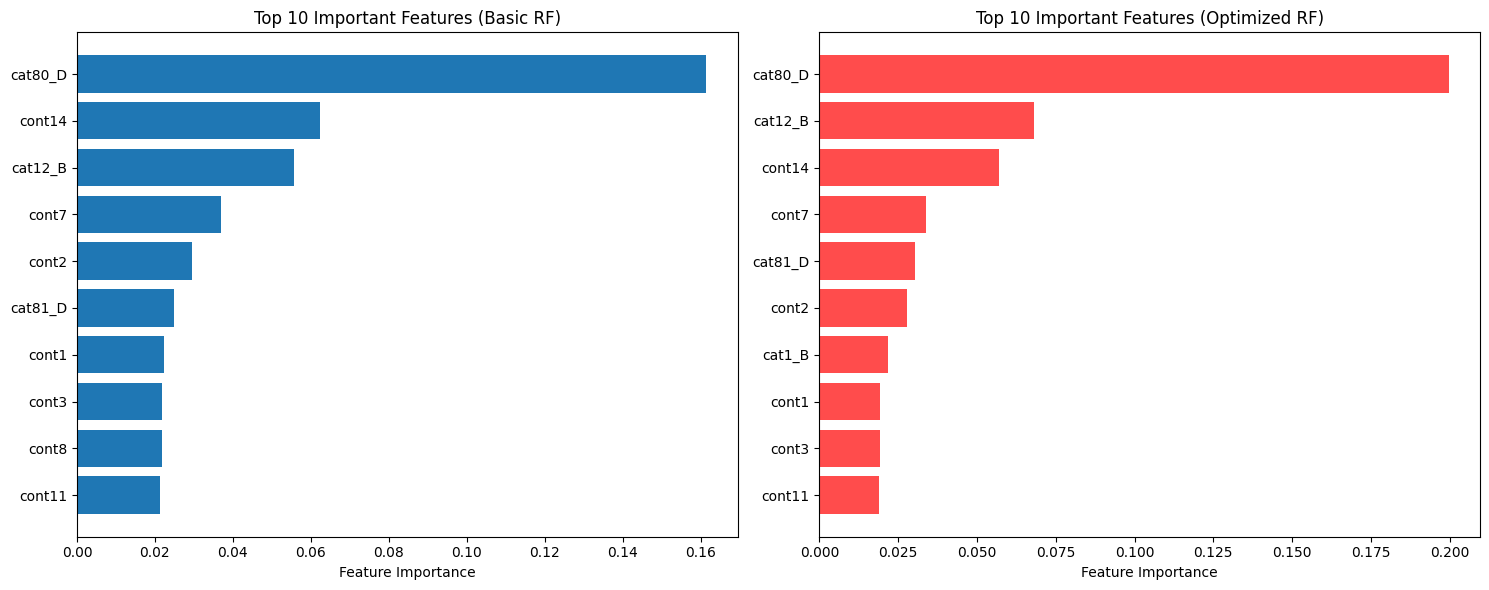

In [30]:
# Fit models to the training dataset
rf_basic = RandomForestRegressor()
rf_basic.fit(X_train, y_train)
rf_best.fit(X_train, y_train)

# Obtain the feature importance
basic_importances = rf_basic.feature_importances_
optimized_importances = rf_best.feature_importances_

# Obtain the column name
feature_names = X_train.columns

# Obtain the Top 10 features indices
basic_indices = np.argsort(basic_importances)[-10:]  # Top 10 in ascending order
optimized_indices = np.argsort(optimized_importances)[-10:]  # Top 10 in ascending order

# Plot the feature importance chart for Basic RF and Optimized RF
plt.figure(figsize=(15, 6))

# Basic RF - Top 10 features
plt.subplot(1, 2, 1)
plt.barh(range(10), basic_importances[basic_indices], align='center')
plt.yticks(range(10), [feature_names[i] for i in basic_indices])  # Show top 10 feature names
plt.title('Top 10 Important Features (Basic RF)')
plt.xlabel('Feature Importance')

# Optimized RF - Top 10 features
plt.subplot(1, 2, 2)
plt.barh(range(10), optimized_importances[optimized_indices], align='center', color='r', alpha=0.7)
plt.yticks(range(10), [feature_names[i] for i in optimized_indices])  # Show top 10 feature names
plt.title('Top 10 Important Features (Optimized RF)')
plt.xlabel('Feature Importance')

plt.tight_layout()
plt.show()

In [28]:
for i in basic_indices:
    print(f"Basic RF - Top feature: {feature_names[i]}")

for i in optimized_indices:
    print(f"Optimized RF - Top feature: {feature_names[i]}")

Basic RF - Top feature: cont11
Basic RF - Top feature: cont8
Basic RF - Top feature: cont3
Basic RF - Top feature: cont1
Basic RF - Top feature: cat81_D
Basic RF - Top feature: cont2
Basic RF - Top feature: cont7
Basic RF - Top feature: cat12_B
Basic RF - Top feature: cont14
Basic RF - Top feature: cat80_D
Optimized RF - Top feature: cont11
Optimized RF - Top feature: cont3
Optimized RF - Top feature: cont1
Optimized RF - Top feature: cat1_B
Optimized RF - Top feature: cont2
Optimized RF - Top feature: cat81_D
Optimized RF - Top feature: cont7
Optimized RF - Top feature: cont14
Optimized RF - Top feature: cat12_B
Optimized RF - Top feature: cat80_D


4.2 Check model prediction accuracy. Unfortunately, the R2 only has a minimun improvement.

In [39]:
# Make predictions using the basic model
y_pred_basic = rf_basic.predict(X_test)

# Make predictions using the tuned model
y_pred_optimized = rf_best.predict(X_test)

y_test_exp = np.exp(y_test)
y_pred_basic_exp = np.exp(y_pred_basic)
y_pred_optimized_exp = np.exp(y_pred_optimized)

# Calculate R² for the basic model
rmse_basic = np.sqrt(mean_squared_error(y_test_exp, y_pred_basic_exp))
# Calculate R² for the optimized model
rmse_optimized = np.sqrt(mean_squared_error(y_test_exp, y_pred_optimized_exp))

# Display the results
print(f'Basic RF - RMSE: {rmse_basic}')
print(f'Optimized RF - RMSE: {rmse_optimized}')

Basic RF - RMSE: 1334.4970671991346
Optimized RF - RMSE: 1329.0182438041793


In [41]:
from sklearn.metrics import mean_absolute_error
mae_basic = mean_absolute_error(y_test_exp, y_pred_basic_exp)
mae_optimized = mean_absolute_error(y_test_exp, y_pred_optimized_exp)
# Display the results
print(f'Basic RF - MAE: {mae_basic}')
print(f'Optimized RF - MAE: {mae_optimized}')

Basic RF - MAE: 950.8171023923929
Optimized RF - MAE: 945.0688508674269


**Summary on this step:** In the modeling part, we chose the random forest as the final model, after hyper parameter tuning, the RMSE reduced a lttle bit and the MAE is also better than the basic model.